In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display
import omx

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
from torchinfo import summary

In [3]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

In [4]:
def switch_func(r_norm,r_cutoff=6.0):
    r_cutoff_smth=0.1
    s=torch.zeros_like(r_norm)
    x=torch.zeros_like(r_norm)
    mask=(r_norm<r_cutoff)
    x[mask]=(r_norm[mask]-r_cutoff_smth)/(r_cutoff-r_cutoff_smth)
    s[mask]=(x[mask]*x[mask]*x[mask]*(-6*x[mask]*x[mask]+15*x[mask]-10)+1)/r_norm[mask]
    return s

In [5]:
def convert_relative(coords,atom_i_idxs,atom_j_idxs):
    relative_coords=coords[:,atom_j_idxs]-coords[:,atom_i_idxs]
    return relative_coords

In [6]:
def convert_general(relative_coords):
    general_coords=torch.zeros(relative_coords.shape[0],relative_coords.shape[1],4)
    relative_coords_norm=torch.linalg.norm(relative_coords,dim=2)
    s_vec=switch_func(relative_coords_norm)
    general_coords[:,:,0]=s_vec
    general_coords[:,:,1:]=relative_coords*s_vec.unsqueeze(-1)/relative_coords_norm.unsqueeze(-1)
    return general_coords

In [94]:
class ThreeLayerPerceptron(nn.Module):
    def __init__(self,n_input,n_hiddens,n_output):
        super(ThreeLayerPerceptron,self).__init__()
        self.l1 = nn.Linear(n_input, n_hiddens[0])
        self.l2 = nn.Linear(n_hiddens[0], n_hiddens[1])
        self.l3 = nn.Linear(n_hiddens[1], n_hiddens[2])
        self.l4 = nn.Linear(n_hiddens[2], n_output)
        self.relu = nn.ReLU(inplace=True)  
    def forward(self,x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        x6 = self.relu(x5)
        x7 = self.l4(x6)
        return x7

In [95]:
class DeepPotSE(nn.Module):
    def __init__(
        self,M1,M2
        ):
        super(DeepPotSE,self).__init__()
        self.M1=M1
        self.M2=M2

        self.embedding_net=ThreeLayerPerceptron(
            n_input=1,
            n_hiddens=[10,20,40],
            n_output=M1
        )

        self.fitting_net=ThreeLayerPerceptron(
            n_input=M1*M2,
            n_hiddens=[100,100,100],
            n_output=1
        )

    def forward(
        self,coords,atom_i_idxs,atom_j_idxs
        ):
        coords.requires_grad_(True)
        relative_coords=convert_relative(coords,atom_i_idxs,atom_j_idxs)
        general_coords=convert_general(relative_coords)
        
        g_vec=general_coords[:,:,0].reshape(-1,1)

        Gi1s=self.embedding_net(g_vec).reshape(coords.shape[0],coords.shape[1],sel,M1)
        Gi2s=Gi1s[:,:,:,:M2]

        general_coords=general_coords.reshape(coords.shape[0],coords.shape[1],sel,4)
        left=torch.matmul(
            torch.transpose(Gi1s,2,3),
            general_coords
        )
        right=torch.matmul(
            torch.transpose(general_coords,2,3),
            Gi2s
        )
        Dis=torch.matmul(left,right)
        Dis_reshaped=Dis.reshape(coords.shape[0],coords.shape[1],M1*M2)
        total_potential_energy=torch.sum(
            self.fitting_net(Dis_reshaped)
        ,dim=1)

        return total_potential_energy

In [96]:
file_name = "Methane"
fname = f"{file_name}.dat"
mdname = f"{file_name}.md"
atom_names, atom_numbs, atom_types, cells = omx.load_param_file(fname, mdname)
coords, steps = omx.load_data(mdname, atom_names, np.sum(atom_numbs))
energy, force = omx.to_system_label(fname, mdname)

In [97]:
n_frame=coords.shape[0]
n_atom=np.sum(atom_numbs)
sel=4
coords=torch.tensor(coords).float()
atom_i_idxs=torch.tensor([[i]*sel for i in range(n_atom)]).reshape(-1)
atom_j_idxs=torch.tensor([list(set([0,1,2,3,4])-{i}) for i in range(n_atom)]).reshape(-1)

In [98]:
M1,M2=100,50
model=DeepPotSE(M1,M2)
total_potential_energy=model(coords,atom_i_idxs,atom_j_idxs)
total_potential_energy.shape
# summary(model)

torch.Size([200, 1])

In [99]:
lr=0.001
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=lr)
num_epochs=200
history=np.zeros((0,2))

In [100]:
labels=torch.tensor(energy).float().view(-1,1)+223
# labels+223

In [101]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    total_potential_energy=model(coords,atom_i_idxs,atom_j_idxs)

    loss=criterion(total_potential_energy,labels)

    loss.backward()

    optimizer.step()

    if epoch%1==0:
        history=np.vstack((history,np.array([epoch,loss.item()])))
        if epoch%10==0:
            print(f"{epoch},{loss}")

0,0.034132808446884155
10,0.0033799889497458935
20,0.002967814216390252
30,0.0027181857731193304
40,0.002664310624822974
50,0.00267293700017035
60,0.002662248909473419
70,0.0026622682344168425
80,0.0026604323647916317
90,0.0026599073316901922
100,0.002659618854522705
110,0.0026593166403472424
120,0.0026589976623654366
130,0.0026587038300931454
140,0.0026583790313452482


KeyboardInterrupt: 

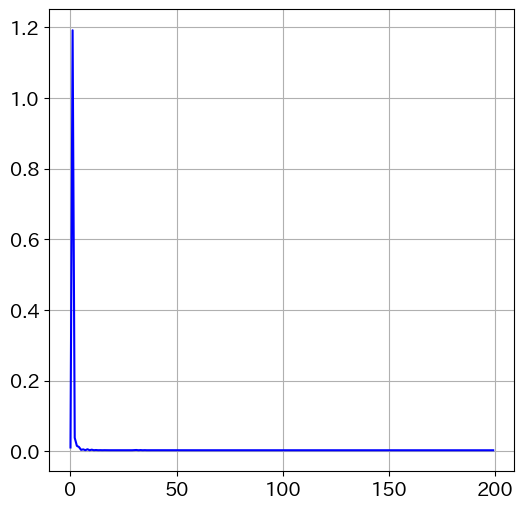

In [79]:
plt.plot(history[:,0],history[:,1],"b")

In [80]:
total_potential_energy_np=total_potential_energy.detach().numpy()
labels_np=labels.detach().numpy()

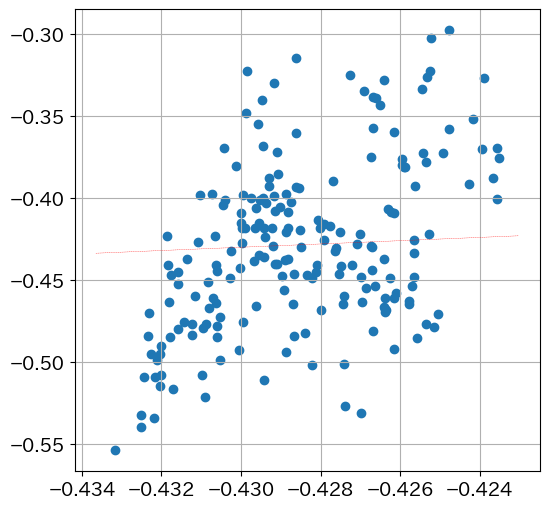

In [81]:
plt.scatter(total_potential_energy_np,labels_np)
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x_range, x_range, "r--", linewidth=0.25)